In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

# Import Dataset

In [2]:
# Load Dataset
movie_data = pd.read_excel("Rotten_Tomatoes_Movies3.xls")


In [3]:
# Dataset Info
movie_data.head(3)

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0


# Data Preprocessing and Feature Extraction

In [4]:
movie_data.info()
movie_data.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16638 non-null  object        
 1   movie_info          16614 non-null  object        
 2   critics_consensus   8309 non-null   object        
 3   rating              16638 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   writers             15289 non-null  object        
 7   cast                16354 non-null  object        
 8   in_theaters_date    15823 non-null  datetime64[ns]
 9   on_streaming_date   16636 non-null  datetime64[ns]
 10  runtime_in_minutes  16483 non-null  float64       
 11  studio_name         16222 non-null  object        
 12  tomatometer_status  16638 non-null  object        
 13  tomatometer_rating  16638 non-null  int64     

critics_consensus     8329
writers               1349
in_theaters_date       815
studio_name            416
cast                   284
audience_rating        252
runtime_in_minutes     155
directors              114
movie_info              24
genre                   17
on_streaming_date        2
movie_title              0
rating                   0
tomatometer_status       0
tomatometer_rating       0
tomatometer_count        0
dtype: int64

In [5]:
# Drop Irrelevant Features
movie_data.drop([
    'tomatometer_count', 'critics_consensus', 'writers', 'in_theaters_date',
    'studio_name', 'cast', 'runtime_in_minutes', 'genre', 'directors',
    'movie_info', 'on_streaming_date', 'movie_title'
], axis=1, inplace=True)


In [6]:
# Remove Missing Values
movie_data.dropna(inplace=True, axis=0)
print("Data Shape After Dropping Nulls:", movie_data.shape)


Data Shape After Dropping Nulls: (16386, 4)


In [7]:
# Statistical Description
print(movie_data.describe())


       tomatometer_rating  audience_rating
count        16386.000000     16386.000000
mean            60.327963        60.470829
std             28.588650        20.462368
min              0.000000         0.000000
25%             38.000000        45.000000
50%             66.000000        62.000000
75%             85.000000        77.000000
max            100.000000       100.000000


# Visulaize the Data

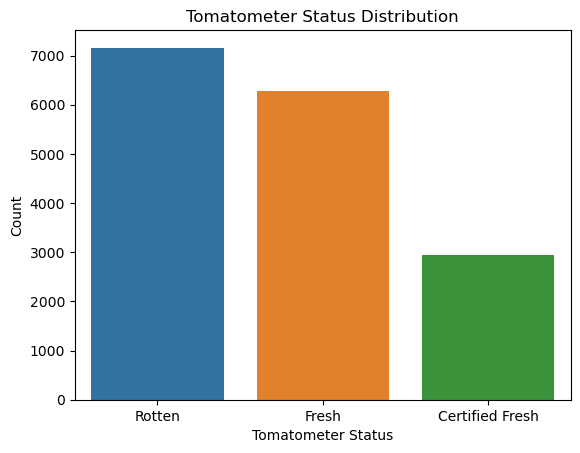

In [8]:
sns.barplot(data=movie_data, x=movie_data['tomatometer_status'].value_counts().index, y=movie_data['tomatometer_status'].value_counts())
plt.title('Tomatometer Status Distribution')
plt.xlabel('Tomatometer Status')
plt.ylabel('Count')
plt.show()


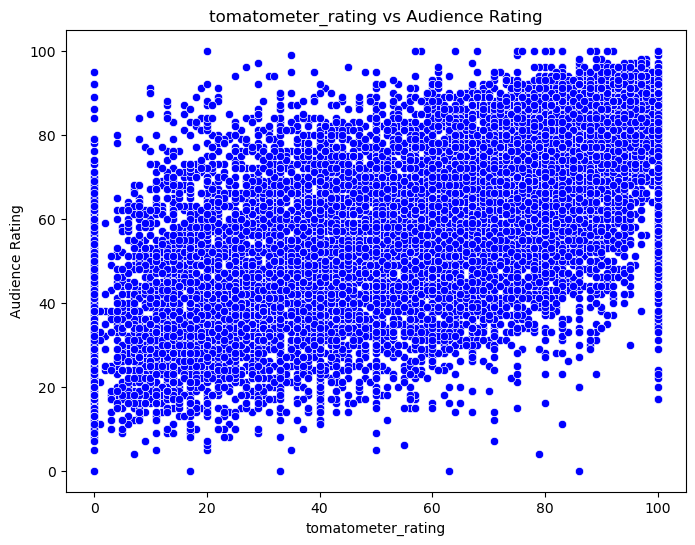

In [11]:
# Scatterplot for Key Numerical Features vs Audience Score
numerical_features = movie_data.select_dtypes(include=np.number).columns
for feature in numerical_features:
    if feature != 'audience_rating':
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=movie_data, x=feature, y='audience_rating', color='blue')
        plt.title(f'{feature} vs Audience Rating')
        plt.xlabel(feature)
        plt.ylabel('Audience Rating')
        plt.show()

rating
R         6116
NR        4650
PG-13     2876
PG        2051
G          652
NC17        37
PG-13)       3
R)           1
Name: count, dtype: int64


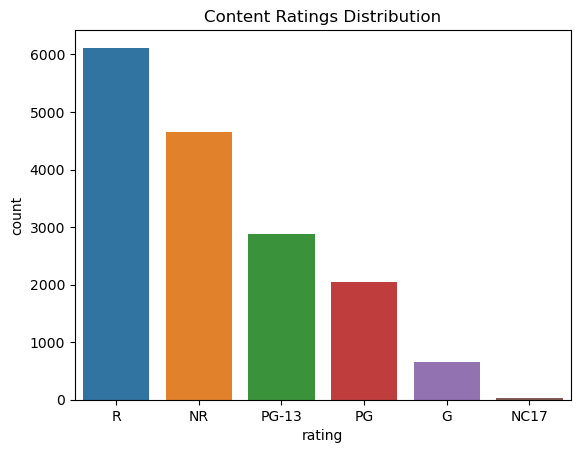

In [12]:
# Rating Distribution
print(movie_data['rating'].value_counts())
movie_data.rating = movie_data.rating.str.replace(r'\)$', '', regex=True)
sns.countplot(data=movie_data, x='rating', order=movie_data['rating'].value_counts().index)
plt.title('Content Ratings Distribution')
plt.show()

In [13]:
# Convert Ratings to Numeric
movie_data['rating'].replace(['R', 'NR', 'PG-13', 'PG', 'G', 'NC17'], [0, 1, 2, 3, 4, 5], inplace=True)


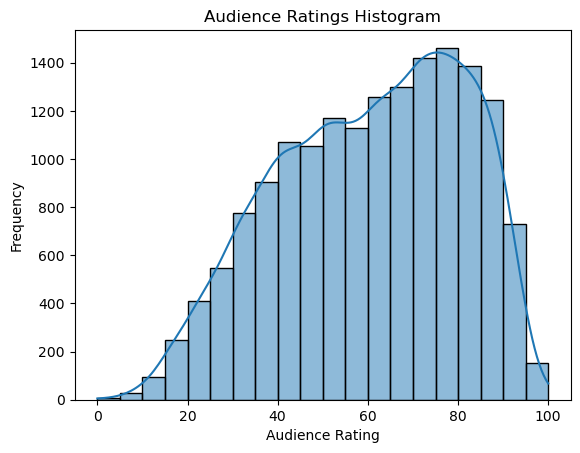

In [14]:
# Histogram of Audience Ratings
sns.histplot(movie_data['audience_rating'], bins=20, kde=True)
plt.title('Audience Ratings Histogram')
plt.xlabel('Audience Rating')
plt.ylabel('Frequency')
plt.show()


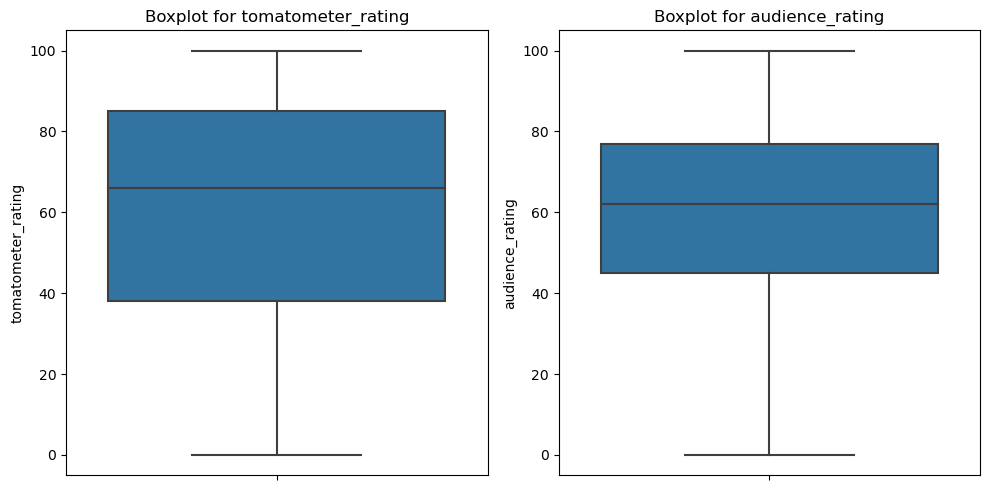

In [15]:
# Outlier Analysis
features_to_check = ['tomatometer_rating', 'audience_rating']
plt.figure(figsize=(10, 5))
for idx, feature in enumerate(features_to_check):
    plt.subplot(1, 2, idx + 1)
    sns.boxplot(y=movie_data[feature])
    plt.title(f'Boxplot for {feature}')
plt.tight_layout()
plt.show()



In [16]:
# Handle Outliers
sorted_data = movie_data.loc[movie_data['audience_rating'].sub(movie_data['tomatometer_rating']).abs().sort_values().index]
low_dispersion_data = sorted_data.iloc[:int(len(sorted_data)/2)]
low_dispersion_data.loc[low_dispersion_data['tomatometer_rating'] == 0, 'tomatometer_rating'] = low_dispersion_data['audience_rating']
low_dispersion_data.loc[low_dispersion_data['audience_rating'] == 0, 'audience_rating'] = low_dispersion_data['tomatometer_rating']

In [17]:
# Encoding Status
encoded_status = pd.get_dummies(low_dispersion_data['tomatometer_status'])
final_movie_data = pd.concat([low_dispersion_data, encoded_status], axis=1).drop(['tomatometer_status'], axis=1)


In [18]:
# Split Data for Modeling
features = final_movie_data.drop(['audience_rating'], axis=1)
labels = final_movie_data['audience_rating']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Model Implementation and Evaluation

In [19]:
# Model Implementation and Evaluation
model_comparison = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=1.0),
    "DecisionTree": DecisionTreeRegressor(),
    "XGBRegressor": XGBRegressor(objective='reg:squarederror', random_state=42),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(random_state=42)
}

evaluation_results = []
for model_name, model in model_comparison.items():
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)  
    evaluation_results.append({
        "Model": model_name,
        "Mean Squared Error": mean_squared_error(y_test, y_pred),
        "Root Mean Squared Error": np.sqrt(mean_squared_error(y_test, y_pred)),
        "Explained Variance Score": explained_variance_score(y_test, y_pred),
        "R-Square Score": r2_score(y_test, y_pred)
    })

# Round Evaluation Results
evaluation_results_rounded = [
    {
        "Model": result["Model"],
        "Mean Squared Error": round(result["Mean Squared Error"], 3),
        "Root Mean Squared Error": round(result["Root Mean Squared Error"], 3),
        "Explained Variance Score": round(result["Explained Variance Score"], 3),
        "R-Square Score": round(result["R-Square Score"], 3),
    }
    for result in evaluation_results
]


In [20]:
results_summary = pd.DataFrame(evaluation_results_rounded)
print(results_summary.to_markdown(index=False))


| Model            |   Mean Squared Error |   Root Mean Squared Error |   Explained Variance Score |   R-Square Score |
|:-----------------|---------------------:|--------------------------:|---------------------------:|-----------------:|
| LinearRegression |               43.62  |                     6.605 |                      0.909 |            0.909 |
| Lasso            |               44.488 |                     6.67  |                      0.908 |            0.908 |
| DecisionTree     |               46.975 |                     6.854 |                      0.902 |            0.902 |
| XGBRegressor     |               45.835 |                     6.77  |                      0.905 |            0.905 |
| Ridge            |               43.62  |                     6.605 |                      0.909 |            0.909 |
| RandomForest     |               46.757 |                     6.838 |                      0.903 |            0.903 |


# Determine the best model

In [21]:
# Best Model by R-Square Score
best_model = results_summary.loc[results_summary['R-Square Score'].idxmax()]
print(f"Best Model: {best_model['Model']} with R-Square Score: {best_model['R-Square Score']:.2f}")

Best Model: LinearRegression with R-Square Score: 0.91


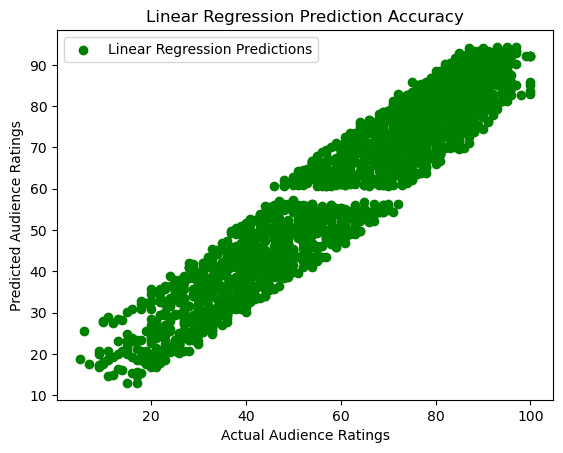

In [22]:
# Prediction Scatter Plot for Linear Regression
predicted_values_lr = model_comparison["LinearRegression"].predict(X_test)
plt.scatter(y_test, predicted_values_lr, color='green', label='Linear Regression Predictions')
plt.xlabel('Actual Audience Ratings')
plt.ylabel('Predicted Audience Ratings')
plt.legend()
plt.title('Linear Regression Prediction Accuracy')
plt.show()

# Linear Regression is the best model

# END